# intro

The goal of this notebook will be to reproduce the ASTE paper figure 2, which includes the mean circulation patterns

In [1]:
# import packages and functions
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from matplotlib.colors import ListedColormap, BoundaryNorm


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd  # For rolling mean
from scipy.ndimage import binary_dilation
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap


In [3]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)
tstart = 3

In [4]:
# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

In [5]:
# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan
hfC[hfC<1] = np.nan

In [6]:
# define the gateways
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

x_nzru = np.full((5),37)
y_nzru = np.arange(460,465,1)

gates = np.full(mskBasin.shape,np.nan)
gates[y_bso,x_bso] = 1
gates[y_sfj,x_sfj] = 2
gates[y_fjnz,x_fjnz] = 3
gates[y_nzru,x_nzru] = 4

In [7]:
# define the Barents Sea up to the NZRU opening
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan

# load the velocity fields - check this is what An is doing

In [8]:
lon = get_aste_tracer(mygrid['XC'],nfx,nfy)[0]
lat = get_aste_tracer(mygrid['YC'],nfx,nfy)[0]

In [9]:
# define the index depth of the AW and the ArW
print(np.cumsum(mygrid['DRF'])[4])
print(np.cumsum(mygrid['DRF'])[10])

50.0
110.47


In [10]:
# maybe we should try with just the surface currents and surface SST to see what this looks like
# we can just include average temperature fields to see
# create panel A with SST

# get the theta and salt for all years

all_SST = np.full((len(allyears[tstart:]),12,ny,nx),np.nan)
all_SSS = np.full((len(allyears[tstart:]),12,ny,nx),np.nan)


iy = 0
it = 0
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    thisyear_SST = np.full((len(tsstr),ny,nx),np.nan)  # one year length
    thisyear_SSS = np.full((len(tsstr),ny,nx),np.nan)  # one year length

    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC
        SALTi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[1])  # degC
    
        thisyear_SST[i,:,:] = np.reshape(THETAi,(nz,ny,nx))[0] # just add SST
        thisyear_SSS[i,:,:] = np.reshape(SALTi,(nz,ny,nx))[0] # just add SST


    # get theta and salt alone so we can use for the freshwater content
    all_SST[iy,:,:,:] = thisyear_SST
    all_SSS[iy,:,:,:] = thisyear_SSS
    
    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [11]:
# get the velocity fields at a specific depth
np.linspace(-2, 2, 17)

array([-2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,
        0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ])

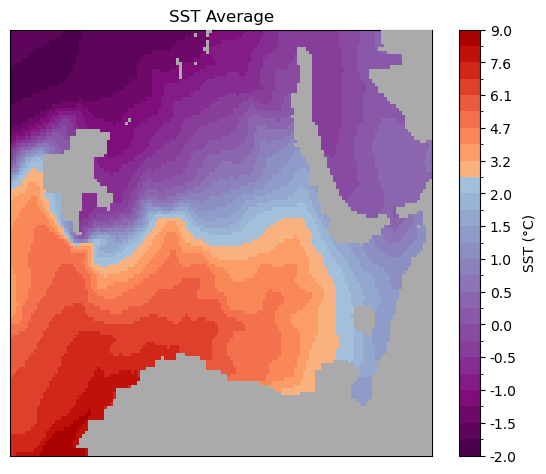

In [12]:
# Compute mean SST over time and months
sst_avg = np.mean(all_SST[:, :, :, :], axis=(0, 1))  # shape (ny, nx)
sst_avg_data = get_aste_tracer(sst_avg, nfx, nfy)[0]  # shape (ny, nx)

# Customize your bounds and color transition here:
cool_max = 2.0
warm_start = 2.5
warm_end = 9.0
cool_steps = 17
warm_steps = 10
blue_cmap_name = 'BuPu_r'
red_cmap_name = 'OrRd'

# ======= BOUND + COLORMAP CREATION =======
# Create custom bounds
bounds = np.concatenate([
    np.linspace(-2, cool_max, cool_steps),        # Cooler part
    np.linspace(warm_start, warm_end, warm_steps) # Warmer part
])

# Create combined colormap
colors = plt.get_cmap(blue_cmap_name, len(bounds) - 1)(np.linspace(0, 1, len(bounds) - 1))
# Replace the tail with red tones
num_red = warm_steps - 1
colors[-num_red:] = plt.get_cmap(red_cmap_name)(np.linspace(0.4, 0.9, num_red))

# Final colormap and norm
cmap = LinearSegmentedColormap.from_list("custom_blue_red", colors)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# ======= PLOTTING =======
plt.figure(figsize=(6, 5))
c = plt.pcolormesh(sst_avg_data, cmap=cmap, norm=norm, shading='auto')

# Overlay land mask
plt.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], zorder=4, cmap="gray_r", vmin=1, vmax=4)

# Colorbar
cb = plt.colorbar(c, label='SST (°C)', ticks=bounds[::2])
cb.ax.set_yticklabels([f'{b:.1f}' for b in bounds[::2]])

# ======= QUIVERS =======


# ======= TITLE =======
plt.title('SST Average')
plt.tight_layout()

# Zoom in to region of interest
plt.xlim(400, 540)
plt.ylim(420, 540)

plt.xticks([])
plt.yticks([])
plt.show()

In [13]:
ArWi = 4  # 20 m
AWi = 14  # 100 m

print(np.cumsum(mygrid['DRC'])[ArWi],np.cumsum(mygrid['DRC'])[AWi])

45.0 154.47


In [14]:
np.cumsum(mygrid['DRC']).astype(int)  # this is the depth at which the velocities are defined

array([   5,   15,   25,   35,   45,   55,   65,   75,   85,   95,  105,
        115,  127,  139,  154,  172,  194,  222,  257,  299,  350,  409,
        477,  552,  634,  722,  814,  909, 1007, 1105, 1205, 1306, 1409,
       1517, 1634, 1765, 1914, 2084, 2276, 2491, 2729, 2990, 3274, 3581,
       3911, 4264, 4640, 5039, 5461, 5906, 6134])

In [15]:
# load the velocity field
dirtrsp = dirrun + "diags/TRSP/"

# read the files for velocity of upper 100m / bottom
names_title = "Yearly"
months_i = np.arange(0,12,1)

all_UVEL_lower = np.zeros((len(allyears[tstart:]),len(months_i),900,540))
all_VVEL_lower = np.zeros((len(allyears[tstart:]),len(months_i),900,540))

all_UVEL_upper = np.zeros((len(allyears[tstart:]),len(months_i),900,540))
all_VVEL_upper = np.zeros((len(allyears[tstart:]),len(months_i),900,540))

iy = 0
# start reading from tstart (here 2006)
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period

    #print(times)
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    for i in range(len(months_i)):
        read_tsstr = tsstr[months_i[i]]
        #print(read_tsstr)
    
        # read the fldList
        file_name = 'trsp_3d_set1'
        meta_trsp_3d_set1 = parsemeta(dirtrsp + file_name + "." + read_tsstr + ".meta")
        fldlist = np.array(meta_trsp_3d_set1["fldList"])
        varnames = np.array(["UVELMASS","VVELMASS"])
        recs = np.array([])
        #print(fldlist)
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        UVELi,its,meta = rdmds(os.path.join(dirtrsp, file_name),int(read_tsstr),returnmeta=True,rec=recs[0])  # m/s
        UVELi = np.reshape(UVELi,(nz,ny,nx))
        VVELi,its,meta = rdmds(os.path.join(dirtrsp, file_name),int(read_tsstr),returnmeta=True,rec=recs[1])  # m/s
        VVELi = np.reshape(VVELi,(nz,ny,nx))

        # get the vector
        Uo,Vo = get_aste_vector_face1_3(UVELi,VVELi,nfx,nfy,False)
        Uo,Vo = Uo[:,:-1,:-1],Vo[:,:-1,:-1]     # centering

        # do averaging in depth and set in bigger array
        all_UVEL_lower[iy,i] = Uo[AWi]
        all_VVEL_lower[iy,i] = Vo[AWi]
        all_UVEL_upper[iy,i] = Uo[ArWi]
        all_VVEL_upper[iy,i] = Vo[ArWi]
    
    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [16]:
# === 1. Compute time-averaged velocities for each layer ===
U_lower_avg = np.mean(all_UVEL_lower, axis=(0, 1))  # shape (ny, nx)
V_lower_avg = np.mean(all_VVEL_lower, axis=(0, 1))
U_upper_avg = np.mean(all_UVEL_upper, axis=(0, 1))
V_upper_avg = np.mean(all_VVEL_upper, axis=(0, 1))

# === 2. Downsample (e.g., every 5 grid points for readability) ===
skip = 5
U_lower_ds = U_lower_avg[::skip, ::skip]
V_lower_ds = V_lower_avg[::skip, ::skip]
U_upper_ds = U_upper_avg[::skip, ::skip]
V_upper_ds = V_upper_avg[::skip, ::skip]

(420.0, 540.0)

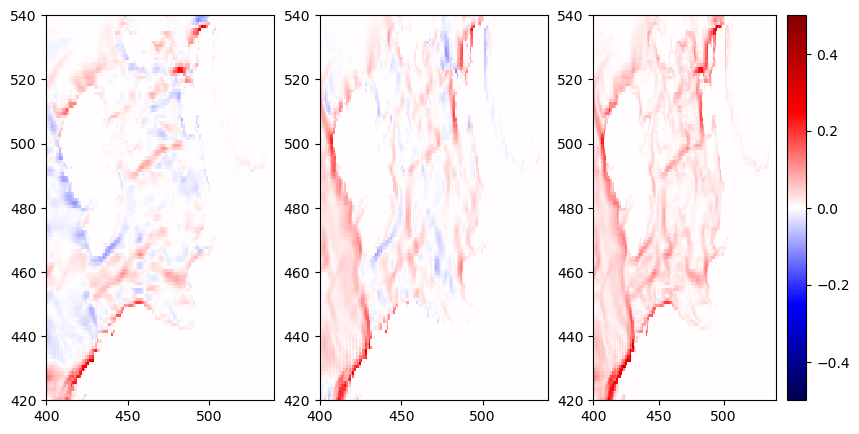

In [17]:
# do a checking of the pcolormesh of uvel to see what this looks like

fig = plt.figure(figsize = (10,5))

ax = plt.subplot(131)
ax.pcolormesh(U_lower_avg,cmap='seismic',vmin=-.5,vmax=.5)
plt.xlim(400, 540)
plt.ylim(420, 540)

ax = plt.subplot(132)
ax.pcolormesh(V_lower_avg,cmap='seismic',vmin=-.5,vmax=.5)
plt.xlim(400, 540)
plt.ylim(420, 540)

ax = plt.subplot(133)
speed = np.sqrt(U_lower_avg**2 + V_lower_avg**2)
cb = ax.pcolormesh(speed,cmap='seismic',vmin=-.5,vmax=.5)
plt.colorbar(cb)
plt.xlim(400, 540)
plt.ylim(420, 540)

In [18]:
# 1. Create SST mask based on 3°C threshold
sst_mask = sst_avg_data < 3  # True where SST < 3

# 2. Downsample SST mask
sst_mask_ds = sst_mask[::skip, ::skip]

# 3. Apply mask to velocity fields
U_upper_masked = np.where(sst_mask_ds, U_upper_ds, np.nan)
V_upper_masked = np.where(sst_mask_ds, V_upper_ds, np.nan)

U_lower_masked = np.where(~sst_mask_ds, U_lower_ds, np.nan)
V_lower_masked = np.where(~sst_mask_ds, V_lower_ds, np.nan)

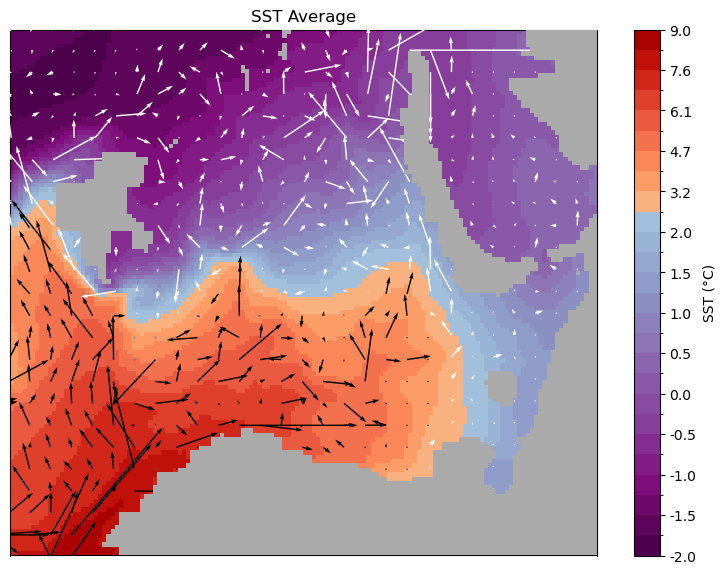

In [19]:
# define the scales for quivers
s1 = 1e0
s2 = 1e0

# Grid coordinates (assuming regular grid)
X, Y = np.meshgrid(np.arange(U_lower_avg.shape[1]), np.arange(U_lower_avg.shape[0]))
X_ds = X[::skip, ::skip]
Y_ds = Y[::skip, ::skip]

# === 3. Plot SST map ===
plt.figure(figsize=(8, 6))
c = plt.pcolormesh(sst_avg_data, cmap=cmap, norm=norm, shading='auto')

# Overlay land mask
plt.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], zorder=4, cmap="gray_r", vmin=1, vmax=4)

# === 4. Overlay quivers ===
# Offset quiver positions
offset = 0.3
X_lower = X_ds - offset
Y_lower = Y_ds - offset
X_upper = X_ds + offset
Y_upper = Y_ds + offset

# Plot quivers with masks applied
plt.quiver(X_upper, Y_upper, U_upper_masked, V_upper_masked, scale=s1,
           color='white', label='100m (upper, SST < 3°C)', zorder=3)

plt.quiver(X_lower, Y_lower, U_lower_masked, V_lower_masked, scale=s2,
           color='black', label='20m (lower, SST ≥ 3°C)', zorder=3)

# === 5. Colorbar and aesthetics ===
# Colorbar
cb = plt.colorbar(c, label='SST (°C)', ticks=bounds[::2])
cb.ax.set_yticklabels([f'{b:.1f}' for b in bounds[::2]])
plt.title('SST Average')
plt.tight_layout()

# Zoom in to region of interest
plt.xlim(400, 540)
plt.ylim(420, 540)

plt.xticks([])
plt.yticks([])
plt.show()

# having trouble resolving the southward flow

- try just doing the southward flow using winter months JFM (0,1,2)
- try looking slightly deeper than previous

In [20]:
ArWi = 4  # 20 m
AWi = 14  # 100 m

print(np.cumsum(mygrid['DRC'])[ArWi],np.cumsum(mygrid['DRC'])[AWi])

45.0 154.47


In [21]:
# maybe we should try with just the surface currents and surface SST to see what this looks like
# we can just include average temperature fields to see
# create panel A with SST

# get the theta and salt for all years

all_SST = np.full((len(allyears[tstart:]),3,ny,nx),np.nan)
all_SSS = np.full((len(allyears[tstart:]),3,ny,nx),np.nan)


iy = 0
it = 0
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    thisyear_SST = np.full((3,ny,nx),np.nan)  # one year length
    thisyear_SSS = np.full((3,ny,nx),np.nan)  # one year length

    for i in range(len(months_i)):
        read_tsstr = int(tsstr[months_i[i]])
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read_tsstr,returnmeta=True,rec=recs[0])  # degC
        SALTi,its,meta = rdmds(os.path.join(dirState, file_name),read_tsstr,returnmeta=True,rec=recs[1])  # degC
    
        thisyear_SST[i,:,:] = np.reshape(THETAi,(nz,ny,nx))[0] # just add SST
        thisyear_SSS[i,:,:] = np.reshape(SALTi,(nz,ny,nx))[0] # just add SST


    # get theta and salt alone so we can use for the freshwater content
    all_SST[iy,:,:,:] = thisyear_SST
    all_SSS[iy,:,:,:] = thisyear_SSS
    
    iy += 1

2006


IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
# load the velocity field
dirtrsp = dirrun + "diags/TRSP/"

# read the files for velocity of upper 100m / bottom
names_title = "JFM"
months_i = np.arange(0,3,1)

all_UVEL_lower = np.zeros((len(allyears[tstart:]),len(months_i),900,540))
all_VVEL_lower = np.zeros((len(allyears[tstart:]),len(months_i),900,540))

all_UVEL_upper = np.zeros((len(allyears[tstart:]),len(months_i),900,540))
all_VVEL_upper = np.zeros((len(allyears[tstart:]),len(months_i),900,540))

iy = 0
# start reading from tstart (here 2006)
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period

    #print(times)
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    for i in range(len(months_i)):
        read_tsstr = tsstr[months_i[i]]
        #print(read_tsstr)
    
        # read the fldList
        file_name = 'trsp_3d_set1'
        meta_trsp_3d_set1 = parsemeta(dirtrsp + file_name + "." + read_tsstr + ".meta")
        fldlist = np.array(meta_trsp_3d_set1["fldList"])
        varnames = np.array(["UVELMASS","VVELMASS"])
        recs = np.array([])
        #print(fldlist)
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        UVELi,its,meta = rdmds(os.path.join(dirtrsp, file_name),int(read_tsstr),returnmeta=True,rec=recs[0])  # m/s
        UVELi = np.reshape(UVELi,(nz,ny,nx))
        VVELi,its,meta = rdmds(os.path.join(dirtrsp, file_name),int(read_tsstr),returnmeta=True,rec=recs[1])  # m/s
        VVELi = np.reshape(VVELi,(nz,ny,nx))

        # get the vector
        Uo,Vo = get_aste_vector_face1_3(UVELi,VVELi,nfx,nfy,False)
        Uo,Vo = Uo[:,:-1,:-1],Vo[:,:-1,:-1]     # centering

        # do averaging in depth and set in bigger array
        all_UVEL_lower[iy,i] = Uo[AWi]
        all_VVEL_lower[iy,i] = Vo[AWi]
        all_UVEL_upper[iy,i] = Uo[ArWi]
        all_VVEL_upper[iy,i] = Vo[ArWi]
    
    iy += 1

In [ ]:
# Compute mean SST over time and months
sst_avg = np.mean(all_SST[:, :, :, :], axis=(0, 1))  # shape (ny, nx)
sst_avg_data = get_aste_tracer(sst_avg, nfx, nfy)[0]  # shape (ny, nx)

In [ ]:
# === 1. Compute time-averaged velocities for each layer ===
U_lower_avg = np.mean(all_UVEL_lower, axis=(0, 1))  # shape (ny, nx)
V_lower_avg = np.mean(all_VVEL_lower, axis=(0, 1))
U_upper_avg = np.mean(all_UVEL_upper, axis=(0, 1))
V_upper_avg = np.mean(all_VVEL_upper, axis=(0, 1))

# === 2. Downsample (e.g., every 5 grid points for readability) ===
skip = 5
U_lower_ds = U_lower_avg[::skip, ::skip]
V_lower_ds = V_lower_avg[::skip, ::skip]
U_upper_ds = U_upper_avg[::skip, ::skip]
V_upper_ds = V_upper_avg[::skip, ::skip]

In [ ]:
# 1. Create SST mask based on 3°C threshold
sst_mask = sst_avg_data < 2.6  # True where SST < 3

# 2. Downsample SST mask
sst_mask_ds = sst_mask[::skip, ::skip]

# 3. Apply mask to velocity fields based on temperature
# U_upper_masked = np.where(sst_mask_ds, U_upper_ds, np.nan)
# V_upper_masked = np.where(sst_mask_ds, V_upper_ds, np.nan)

# U_lower_masked = np.where(~sst_mask_ds, U_lower_ds, np.nan)
# V_lower_masked = np.where(~sst_mask_ds, V_lower_ds, np.nan)


# apply mask to plot with different U for the velocity
# AW section
U_lower_masked = np.where(~sst_mask_ds, U_lower_ds, np.nan)
V_lower_masked = np.where(~sst_mask_ds, V_lower_ds, np.nan)

# subducted section
U_lower_masked_subducted = np.where(sst_mask_ds, U_lower_ds, np.nan)
V_lower_masked_subducted = np.where(sst_mask_ds, V_lower_ds, np.nan)

# mask 0 as nan (this is for the land
U_lower_masked[U_lower_masked==0] = np.nan
V_lower_masked[V_lower_masked==0] = np.nan
U_lower_masked_subducted[U_lower_masked_subducted==0] = np.nan
V_lower_masked_subducted[V_lower_masked_subducted==0] = np.nan

In [27]:
hfC_inverted = np.where(np.isnan(hfC), 1, np.nan)

In [ ]:
# define the scales for quivers
s1 = 2e0
s2 = 1e0
U = 0.05
U2 = 0.05

# Grid coordinates (assuming regular grid)
X, Y = np.meshgrid(np.arange(U_lower_avg.shape[1]), np.arange(U_lower_avg.shape[0]))
X_ds = X[::skip, ::skip]
Y_ds = Y[::skip, ::skip]

# === 3. Plot SST map ===
fig, ax = plt.subplots(figsize=(8, 6))

# Plot SST map
c = ax.pcolormesh(sst_avg_data, cmap=cmap, norm=norm, shading='auto')

# Overlay masks
ax.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], zorder=4, cmap="gray_r", vmin=1, vmax=4)
ax.pcolormesh(get_aste_tracer(hfC_inverted, nfx, nfy)[AWi-1], zorder=3, cmap="gray_r", vmin=0, vmax=10)

# Quivers
q1 = ax.quiver(X_lower, Y_lower, U_lower_masked, V_lower_masked, scale=s1,
               color='black', label=f'{np.cumsum(mygrid["DRC"]).astype(int)[AWi]}m', zorder=3)

q2 = ax.quiver(X_lower, Y_lower, U_lower_masked_subducted, V_lower_masked_subducted, scale=s2,
               color='white', label=f'{np.cumsum(mygrid["DRC"]).astype(int)[AWi]}m', zorder=3)
# Colorbar and labels
cb = fig.colorbar(c, ax=ax, label='SST (°C)', ticks=bounds[::2])
cb.ax.set_yticklabels([f'{b:.1f}' for b in bounds[::2]])

ax.set_title('JFM SST Average')
# ax.legend()

# Zoom and ticks
ax.set_xlim(400, 540)
ax.set_ylim(420, 560)
ax.set_xticks([])
ax.set_yticks


# === Add Quiver Key Box ===
# [left, bottom, width, height] in figure coordinates
ax_quiv = fig.add_axes([0.95, 0.3, 0.2, 0.15])  # pushed farther right
ax_quiv.set_facecolor('#e3e3e3')
ax_quiv.set_xticks([])
ax_quiv.set_yticks([])
for spine in ax_quiv.spines.values():
    spine.set_visible(False)

# Plot a dummy vector so we can use it for the key
q_dummy = ax_quiv.quiver([0.5], [0.5], [1], [0], scale=1)

# Add quiver keys inside this new axis
ax_quiv.quiverkey(q_dummy, X=0.5, Y=0.8, U=U2*2, label=f'{U2*100*2:.0f} cm/s', labelpos='E')
ax_quiv.quiverkey(q_dummy, X=0.5, Y=0.4, U=U*2,  label=f'{U*100*2:.0f} cm/s', labelpos='E',color="white")

# try again -- maybe it makes more sense to look at this over the topography

Try to plot AW currents with temperature and also over the bathymetry plot

In [52]:
AWi = 14
# AWi = 5

In [53]:
# do the temperature of the AW layer

# maybe we should try with just the surface currents and surface SST to see what this looks like
# we can just include average temperature fields to see
# create panel A with SST

# get the theta and salt for all years

all_T_layer = np.full((len(allyears[tstart:]),12,ny,nx),np.nan)

iy = 0
it = 0
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    thisyear_T_layer = np.full((len(tsstr),ny,nx),np.nan)  # one year length

    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC
    
        thisyear_T_layer[i,:,:] = (np.reshape(THETAi,(nz,ny,nx)) * hfC)[AWi] # just add SST


    # get theta and salt alone so we can use for the freshwater content
    all_T_layer[iy,:,:,:] = thisyear_T_layer
    
    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [23]:
# just plot the vectors at AWi
U_lower_masked = U_lower_ds
V_lower_masked = V_lower_ds

In [48]:
t_layer_avg = np.mean(all_T_layer[:, :, :, :], axis=(0, 1))  # shape (ny, nx)
t_layer_avg_data = get_aste_tracer(t_layer_avg, nfx, nfy)[0]  # shape (ny, nx)

In [41]:
from scipy.ndimage import binary_dilation

# add a buffer for the approximate PF
landmask_tr = get_aste_tracer(landmsk, nfx, nfy)[0] > 0  # Boolean mask where land is True
# Step 2: Expand land by 1 grid cell in all directions
landbuffer_tr = binary_dilation(landmask_tr, iterations=1)

sst_avg_data = np.where(landbuffer_tr, np.nan, sst_avg_data)

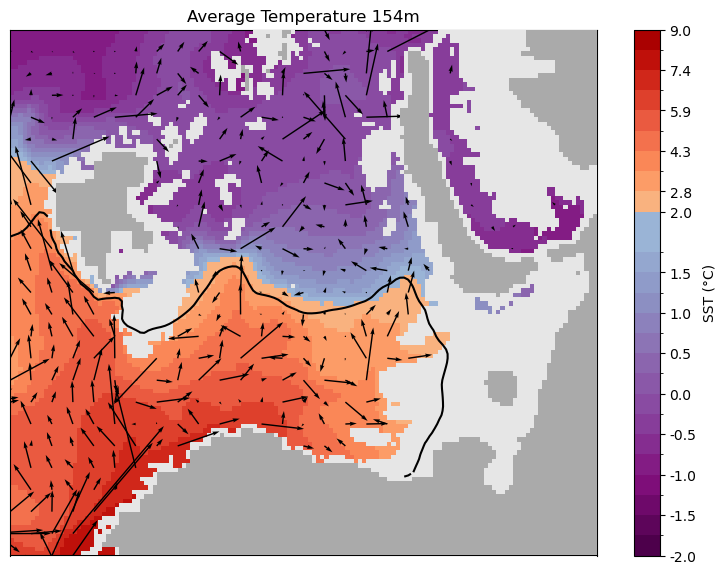

In [58]:
# create the cmap division at 2 degrees because this is where AW becomes BSW
# Customize your bounds and color transition here:
cool_max = 2.0
warm_start = 2
warm_end = 9.0
cool_steps = 17
warm_steps = 10
blue_cmap_name = 'BuPu_r'
red_cmap_name = 'OrRd'

# ======= BOUND + COLORMAP CREATION =======
# Create custom bounds
bounds = np.concatenate([
    np.linspace(-2, cool_max, cool_steps),        # Cooler part
    np.linspace(warm_start, warm_end, warm_steps) # Warmer part
])

# Create combined colormap
colors = plt.get_cmap(blue_cmap_name, len(bounds) - 1)(np.linspace(0, 1, len(bounds) - 1))
# Replace the tail with red tones
num_red = warm_steps - 1
colors[-num_red:] = plt.get_cmap(red_cmap_name)(np.linspace(0.4, 0.9, num_red))

# Final colormap and norm
cmap = LinearSegmentedColormap.from_list("custom_blue_red", colors)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)


# define the scales for quivers
s1 = 1e0
s2 = 1e0

# Grid coordinates (assuming regular grid)
X, Y = np.meshgrid(np.arange(U_lower_avg.shape[1]), np.arange(U_lower_avg.shape[0]))
X_ds = X[::skip, ::skip]
Y_ds = Y[::skip, ::skip]

# === 3. Plot SST map ===
plt.figure(figsize=(8, 6))
c = plt.pcolormesh(t_layer_avg_data, cmap=cmap, norm=norm, shading='auto')

# Overlay land mask
plt.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], zorder=4, cmap="gray_r", vmin=1, vmax=4)
plt.pcolormesh(get_aste_tracer(hfC_inverted, nfx, nfy)[AWi-1], zorder=3, cmap="gray_r", vmin=0, vmax=10)
plt.contour(sst_avg_data,levels=([3]),colors="k",zorder=4)


# === 4. Overlay quivers ===
# Offset quiver positions]

# Plot quivers with masks applied
U_lower_masked[U_lower_masked == 0] = np.nan
V_lower_masked[V_lower_masked == 0] = np.nan
plt.quiver(X_ds, Y_ds, U_lower_masked, V_lower_masked, scale=s2,
           color='black', label='20m (lower, SST ≥ 3°C)', zorder=3)

# === 5. Colorbar and aesthetics ===
# Colorbar
cb = plt.colorbar(c, label='SST (°C)', ticks=bounds[::2])
cb.ax.set_yticklabels([f'{b:.1f}' for b in bounds[::2]])
plt.title('Average Temperature ' + str(np.cumsum(mygrid["DRC"]).astype(int)[AWi]) + "m")
plt.tight_layout()

# Zoom in to region of interest
plt.xlim(400, 540)
plt.ylim(420, 540)

plt.xticks([])
plt.yticks([])
plt.show()

[]

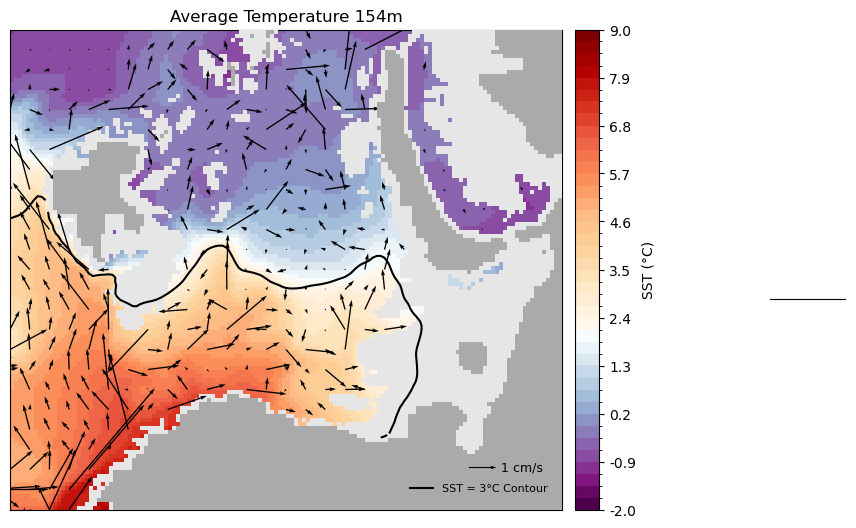

In [91]:
# Define color split and full temperature range
temp_min = -2.0
temp_split = 2.0
temp_max = 9.0
n_steps = 40  # Number of TOTAL bins — adjust for resolution

# Create evenly spaced bins
bounds = np.linspace(temp_min, temp_max, n_steps + 1)  # uniform bins

# Find where the split at 2°C occurs
split_idx = np.searchsorted(bounds, temp_split)

# Get colors: first part blue, second part red
colors_blue = plt.get_cmap('BuPu_r', split_idx)(np.linspace(0, 1, split_idx))
colors_red = plt.get_cmap('OrRd', n_steps - split_idx)(np.linspace(0, 1, n_steps - split_idx))

# Merge the two
colors = np.vstack([colors_blue, colors_red])

# Build final colormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red", colors)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# === 2. Set quiver scaling and grid ===
s1 = 1e0
s2 = 1e0
X, Y = np.meshgrid(np.arange(U_lower_avg.shape[1]), np.arange(U_lower_avg.shape[0]))
X_ds = X[::skip, ::skip]
Y_ds = Y[::skip, ::skip]

U_lower_masked[U_lower_masked == 0] = np.nan
V_lower_masked[V_lower_masked == 0] = np.nan

# === 3. Plot map ===
fig = plt.figure(figsize=(9.5, 6))  # Wider for side key
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])  # Main plot

c = ax.pcolormesh(t_layer_avg_data, cmap=cmap, norm=norm, shading='auto')
ax.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], zorder=4, cmap="gray_r", vmin=1, vmax=4)
ax.pcolormesh(get_aste_tracer(hfC_inverted, nfx, nfy)[AWi-1], zorder=3, cmap="gray_r", vmin=0, vmax=10)

# Contour and label for SST = 3°C
cs = ax.contour(sst_avg_data, levels=[3], colors="k", zorder=4)
# ax.clabel(cs, fmt='SST = %1.0f°C', fontsize=9)

# Quiver overlay
q = ax.quiver(X_ds, Y_ds, U_lower_masked, V_lower_masked, scale=s2, color='black', zorder=3)

# === 4. Colorbar ===
cb = fig.colorbar(c, ax=ax, label='SST (°C)', ticks=bounds[::4], pad=0.02)
cb.ax.set_yticklabels([f'{b:.1f}' for b in bounds[::4]])

# === 5. Quivers ===
ax_quiv = fig.add_axes([0.82, 0.35, 0.16, 0.20])  # Adjust size and placement
ax_quiv.set_facecolor('white')
ax_quiv.set_xticks([])
ax_quiv.set_yticks([])
for spine in ax_quiv.spines.values():
    spine.set_visible(False)

# === Create a dummy quiver ===
# Use the same scale (s2) as the main quiver plot
q_dummy = ax_quiv.quiver(0.5, 0.5, 1, 0, scale=s2, angles='xy', scale_units='xy', color='black')

# === Add a quiver key ===
U_ref = 0.01  # 5 cm/s reference velocity (adjust if needed)
ax_quiv.quiverkey(q_dummy, X=-1.3, Y=-.9, U=U_ref,
                  label=f'{U_ref*100:.0f} cm/s', labelpos='E', labelsep=0.05,
                  fontproperties={'size': 9})

legend_elements = [
    Line2D([0], [0], color='k', linestyle='-', linewidth=1.5, label="SST = 3°C Contour")
]


ax_quiv.legend(handles=legend_elements,
               loc='lower right',
               bbox_to_anchor=(-.9, -1.2),
               fontsize=8,
               frameon=False)

# # === 6. Title, limits, ticks ===
ax.set_title('Average Temperature ' + str(np.cumsum(mygrid["DRC"]).astype(int)[AWi]) + "m")
ax.set_xlim(400, 540)
ax.set_ylim(420, 540)
ax.set_xticks([])
ax.set_yticks([])

# plt.show()


In [96]:
# apply a mask to the above to plot deep currents as stronger and internal currents as weaker

# 1. Create SST mask based on 3°C threshold
depth_mask = get_aste_tracer(mygrid['Depth'],nfx,nfy)[0] > 1000  # True where depth > 600

# 2. Downsample SST mask
depth_mask_ds = depth_mask[::skip, ::skip]

# apply mask to plot with different U for the velocity
# AW section
U_shallow_masked = np.where(~depth_mask_ds, U_lower_ds, np.nan)
V_shallow_masked = np.where(~depth_mask_ds, V_lower_ds, np.nan)

# subducted section
U_deep_masked = np.where(depth_mask_ds, U_lower_ds, np.nan)
V_deep_masked = np.where(depth_mask_ds, V_lower_ds, np.nan)

# mask 0 as nan (this is for the land
U_deep_masked[U_deep_masked==0] = np.nan
V_deep_masked[V_deep_masked==0] = np.nan
U_shallow_masked[U_shallow_masked==0] = np.nan
V_shallow_masked[V_shallow_masked==0] = np.nan

In [104]:
depth_tr = get_aste_tracer(mygrid['Depth'],nfx,nfy)[0]

depth_levels = [1,100,200,300,500]

[]

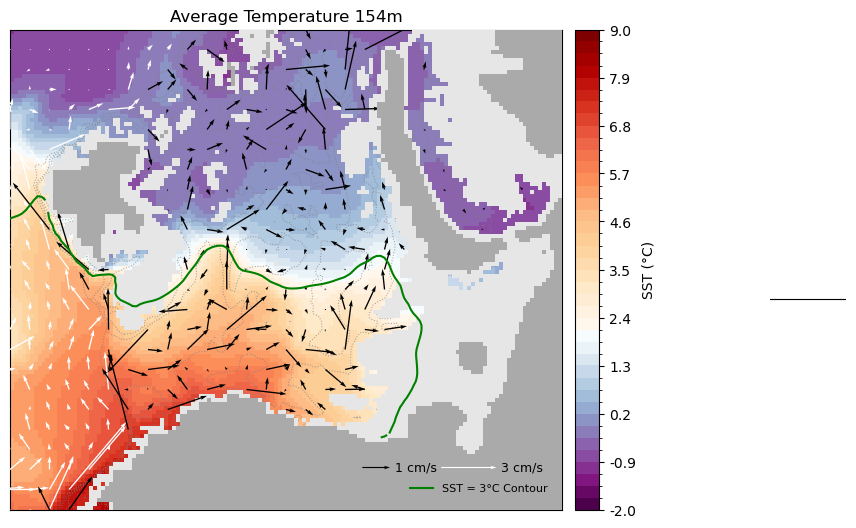

In [115]:
# Define color split and full temperature range
temp_min = -2.0
temp_split = 2.0
temp_max = 9.0
n_steps = 40  # Number of TOTAL bins — adjust for resolution

# Create evenly spaced bins
bounds = np.linspace(temp_min, temp_max, n_steps + 1)  # uniform bins

# Find where the split at 2°C occurs
split_idx = np.searchsorted(bounds, temp_split)

# Get colors: first part blue, second part red
colors_blue = plt.get_cmap('BuPu_r', split_idx)(np.linspace(0, 1, split_idx))
colors_red = plt.get_cmap('OrRd', n_steps - split_idx)(np.linspace(0, 1, n_steps - split_idx))

# Merge the two
colors = np.vstack([colors_blue, colors_red])

# Build final colormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red", colors)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# === 2. Set quiver scaling and grid ===
s1 = 1e0
s2 = 1.5e0
X, Y = np.meshgrid(np.arange(U_lower_avg.shape[1]), np.arange(U_lower_avg.shape[0]))
X_ds = X[::skip, ::skip]
Y_ds = Y[::skip, ::skip]

U_lower_masked[U_lower_masked == 0] = np.nan
V_lower_masked[V_lower_masked == 0] = np.nan

# === 3. Plot map ===
fig = plt.figure(figsize=(9.5, 6))  # Wider for side key
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])  # Main plot

c = ax.pcolormesh(t_layer_avg_data, cmap=cmap, norm=norm, shading='auto')
ax.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], zorder=4, cmap="gray_r", vmin=1, vmax=4)
ax.pcolormesh(get_aste_tracer(hfC_inverted, nfx, nfy)[AWi-1], zorder=3, cmap="gray_r", vmin=0, vmax=10)
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)

# Contour and label for SST = 3°C
cs = ax.contour(sst_avg_data, levels=[3], colors="green", zorder=4)
# ax.clabel(cs, fmt='SST = %1.0f°C', fontsize=9)

# Quiver overlay
q = ax.quiver(X_ds, Y_ds, U_deep_masked, V_deep_masked, scale=s2, color='white', zorder=3)
q2 = ax.quiver(X_ds, Y_ds, U_shallow_masked, V_shallow_masked, scale=s1, color='black', zorder=3)


# === 4. Colorbar ===
cb = fig.colorbar(c, ax=ax, label='SST (°C)', ticks=bounds[::4], pad=0.02)
cb.ax.set_yticklabels([f'{b:.1f}' for b in bounds[::4]])

# === 5. Quivers ===
ax_quiv = fig.add_axes([0.82, 0.35, 0.16, 0.20])  # Adjust size and placement
ax_quiv.set_facecolor('white')
ax_quiv.set_xticks([])
ax_quiv.set_yticks([])
for spine in ax_quiv.spines.values():
    spine.set_visible(False)

# === Create a dummy quiver ===
# Use the same scale (s2) as the main quiver plot
q_dummy = ax_quiv.quiver(0.5, 0.5, 1, 0, scale=s2, angles='xy', scale_units='xy', color='white')
q2_dummy = ax_quiv.quiver(0.5, 0.5, 1, 0, scale=s1, angles='xy', scale_units='xy', color='black')


# === Add a quiver key ===
U_ref = 0.03  # 5 cm/s reference velocity (adjust if needed)
ax_quiv.quiverkey(q_dummy, X=-1.3, Y=-.9, U=U_ref,
                  label=f'{U_ref*100:.0f} cm/s', labelpos='E', labelsep=0.05,
                  fontproperties={'size': 9})
U_ref = 0.01
ax_quiv.quiverkey(q2_dummy, X=-2, Y=-.9, U=U_ref,
                  label=f'{U_ref*100:.0f} cm/s', labelpos='E', labelsep=0.05,
                  fontproperties={'size': 9})

legend_elements = [
    Line2D([0], [0], color='green', linestyle='-', linewidth=1.5, label="SST = 3°C Contour")
]


ax_quiv.legend(handles=legend_elements,
               loc='lower right',
               bbox_to_anchor=(-.9, -1.2),
               fontsize=8,
               frameon=False)

# # === 6. Title, limits, ticks ===
ax.set_title('Average Temperature ' + str(np.cumsum(mygrid["DRC"]).astype(int)[AWi]) + "m")
ax.set_xlim(400, 540)
ax.set_ylim(420, 540)
ax.set_xticks([])
ax.set_yticks([])

# plt.show()

In [129]:
# make two new arrays to see
# 1. Calculate velocity magnitude
velocity_mag = np.sqrt(U_lower_ds**2 + V_lower_ds**2)

# 2. Create masks
mask_greater = velocity_mag > 0.015
mask_less_equal = velocity_mag <= 0.015

# 3. Create new arrays
U_deep_masked = np.where(mask_greater, U_lower_ds, np.nan)   # Keep values where magnitude > 0.01, else NaN
V_deep_masked = np.where(mask_greater, V_lower_ds, np.nan)

U_shallow_masked = np.where(mask_less_equal, U_lower_ds, np.nan)  # Keep values where magnitude <= 0.01, else NaN
V_shallow_masked = np.where(mask_less_equal, V_lower_ds, np.nan)

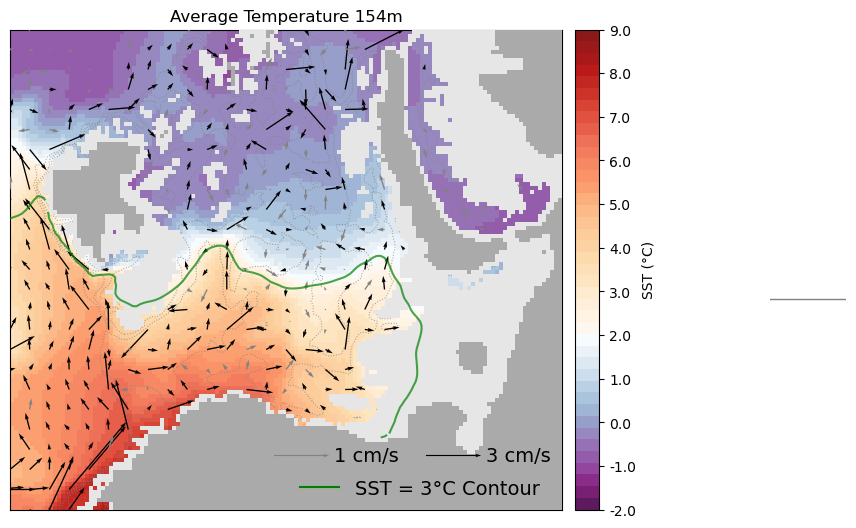

In [143]:
# try one more time

# Define color split and full temperature range
temp_min = -2.0
temp_split = 2.0
temp_max = 9.0
n_steps = 41  # Number of TOTAL bins — adjust for resolution

# Create evenly spaced bins
bounds = np.linspace(temp_min, temp_max, n_steps + 1)  # uniform bins

# Find where the split at 2°C occurs
split_idx = np.searchsorted(bounds, temp_split)

# Get colors: first part blue, second part red
colors_blue = plt.get_cmap('BuPu_r', split_idx)(np.linspace(0, 1, split_idx))
colors_red = plt.get_cmap('OrRd', n_steps - split_idx)(np.linspace(0, 1, n_steps - split_idx))

# Merge the two
colors = np.vstack([colors_blue, colors_red])

# Build final colormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red", colors)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# === 2. Set quiver scaling and grid ===
s1 = 5e-1    # scale for shallow/smaller arrows
s2 = 1.5e0  # scale for deep/stronger arrows
X, Y = np.meshgrid(np.arange(U_lower_avg.shape[1]), np.arange(U_lower_avg.shape[0]))
X_ds = X[::skip, ::skip]
Y_ds = Y[::skip, ::skip]

U_lower_masked[U_lower_masked == 0] = np.nan
V_lower_masked[V_lower_masked == 0] = np.nan

# === 3. Plot map ===
fig = plt.figure(figsize=(9.5, 6))  # Wider for side key
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])  # Main plot

c = ax.pcolormesh(t_layer_avg_data, cmap=cmap, norm=norm, shading='auto',alpha=0.9)
ax.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], zorder=4, cmap="gray_r", vmin=1, vmax=4)
ax.pcolormesh(get_aste_tracer(hfC_inverted, nfx, nfy)[AWi-1], zorder=3, cmap="gray_r", vmin=0, vmax=10)
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)

# Contour and label for SST = 3°C
cs = ax.contour(sst_avg_data, levels=[3], colors="green", zorder=4,alpha=0.7)
# ax.clabel(cs, fmt='SST = %1.0f°C', fontsize=9)

# Quiver overlay
q = ax.quiver(X_ds, Y_ds, U_deep_masked, V_deep_masked, scale=s2, color='black', zorder=3)
q2 = ax.quiver(X_ds, Y_ds, U_shallow_masked, V_shallow_masked, scale=s1, color='#828282', zorder=3)


# === 4. Colorbar ===
# Choose major ticks manually
ticks = np.arange(-2, 9.1, 1)  # Tick every 1°C from -2 to 9
cb = fig.colorbar(c, ax=ax, label='SST (°C)', ticks=ticks, pad=0.02)
cb.ax.minorticks_off()
cb.ax.set_yticklabels([f'{b:.1f}' for b in ticks])

# === 5. Quivers ===
ax_quiv = fig.add_axes([0.82, 0.35, 0.16, 0.20])  # Adjust size and placement
ax_quiv.set_facecolor('white')
ax_quiv.set_xticks([])
ax_quiv.set_yticks([])
for spine in ax_quiv.spines.values():
    spine.set_visible(False)

# === Create a dummy quiver ===
# Use the same scale (s2) as the main quiver plot
q_dummy = ax_quiv.quiver(0.5, 0.5, 1, 0, scale=s2, angles='xy', scale_units='xy', color='black')
q2_dummy = ax_quiv.quiver(0.5, 0.5, 1, 0, scale=s1, angles='xy', scale_units='xy', color='#828282')


# === Add a quiver key ===
U_ref = 0.03  # 5 cm/s reference velocity (adjust if needed)
ax_quiv.quiverkey(q_dummy, X=-1.4, Y=-.8, U=U_ref,
                  label=f'{U_ref*100:.0f} cm/s', labelpos='E', labelsep=0.05,
                  fontproperties={'size': 14})
U_ref = 0.01
ax_quiv.quiverkey(q2_dummy, X=-2.4, Y=-.8, U=U_ref,
                  label=f'{U_ref*100:.0f} cm/s', labelpos='E', labelsep=0.05,
                  fontproperties={'size': 14})

legend_elements = [
    Line2D([0], [0], color='green', linestyle='-', linewidth=1.5, label="SST = 3°C Contour")
]


ax_quiv.legend(handles=legend_elements,
               loc='lower right',
               bbox_to_anchor=(-.9, -1.3),
               fontsize=14,
               frameon=False)

# # === 6. Title, limits, ticks ===
ax.set_title('Average Temperature ' + str(np.cumsum(mygrid["DRC"]).astype(int)[AWi]) + "m")
ax.set_xlim(400, 540)
ax.set_ylim(420, 540)
ax.set_xticks([])
ax.set_yticks([])


plt.savefig("figs/AWtransport.png",dpi=300)
# plt.show()

In [ ]:
# plot the same as the above and put a slight cross for the cross sections